In [3]:
%matplotlib inline

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from sklearn.mixture import GaussianMixture
import sys
sys.path.append('../src/')
from forward_modeling import project_volume, slice_volume
from molecular_handling import particle
from scipy.interpolate import RegularGridInterpolator
from scipy.stats import norm

In [12]:
def gmm_image_dataset(particles,size=100,noise=0.1,size_grid=32):
    """
    This function creates a dataet of images of a set of particles: 
    for each image, we randomly choose one of the particle of the set, rotate it along the z axis, and add some noise.
    
        Arguments:
        ---------
        - particles (list): 
            list of the different particles in the dataset
        - size (int {default:100}): 
            lentgh of the dataset
        - noise (float {default: 0.1}):
            noise added to the images
        - size_grid (integer {default:32}):
            number of voxels along each grid direction
    """
    dataset = np.zeros((size, size_grid, size_grid))
    n_particles = len(particles)
    for t in range(size):
        iat = np.random.randint(n_particles)
        angle = np.random.rand() * 360
        rot = R.from_euler('z', angle, degrees = True)
        
        particles[iat].rotate(rotvec = rot.as_rotvec())
        dataset[t,:,:] = particles[iat].image
    
    return dataset + np.random.randn(dataset.shape[0], dataset.shape[1], dataset.shape[2])*noise

In [19]:
crds_1 = np.array([[2.,2.,2.],
                   [2.,8.,8.],
                   [8.,8.,2.],
                   [8.,2.,8.]
                  ])
crds_2 = np.array([[2.,2.,2.],
                   [8.,8.,8.],
                  ])
crds_3 = np.array([[5.,5.,5.],
                  ])

particle1 = particle(n_atom=4, rads_atom=[1.,1.,1.,1.], size_grid = 32, crds = crds_1)
particle2 = particle(n_atom=2, rads_atom=[2.,2.], size_grid = 32, crds = crds_2)
particle3 = particle(n_atom=1, rads_atom=[3.], size_grid = 32, crds = crds_3)
particles = [particle1, particle2, particle3]

In [20]:
dataset = gmm_image_dataset(particles, noise=0.1)

# Simple gaussian mixture model applied directly to the images

Here, we simply train a gaussian mixture model on the dataset, and compare the images of the particles, and the means of the gaussians of the model.

In [21]:
reshaped_dataset = dataset.reshape(100,1024)
gm = GaussianMixture(3)
gm.fit(reshaped_dataset)

images = gm.means_.reshape(3,32,32)

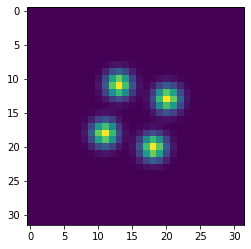

In [22]:
plt.imshow(particle1.image)

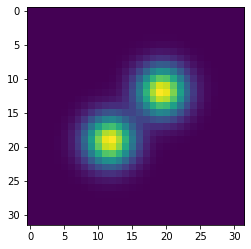

In [23]:
plt.imshow(particle2.image)

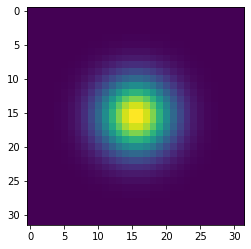

In [24]:
plt.imshow(particle3.image)

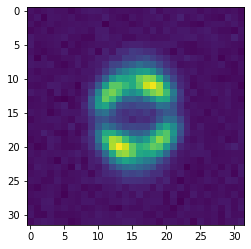

In [25]:
plt.imshow(images[0])

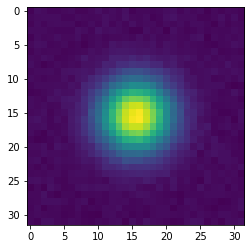

In [26]:
plt.imshow(images[1])

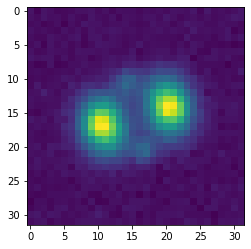

In [27]:
plt.imshow(images[2])

It worked quite good without having to find the orientations

# Marginalizing over the orientations

In this part, we built an algorithm that reconstruct the images of the particles, by marginalizing over the orientations. In this approach, we treat the heterogeneity as in Relion, by assuming that all particles comes from a finite number of conformations. 

Let use the following notations:
- $(X)_i$ the image dataset, containing rotation of a finite number of particle images, with noise added.
- $(\theta)_j$ a set of orientations (regularly sampled between 0 and 360 degrees)
- $R_\theta (X_i)$ the rotation of $X_i$ by angle $\theta$ 
- $(I)_k^{(t)}$ a finite set of images representing the particle images at iteration t (the number of conformations we are looking for)

We first need to define a probability score telling us how close are two images: 

$$P(X,I) = \prod_{l} P(N >|X_l - I_l|)$$ 
with $N$ a zero mean gaussian (the scale will be chosen afterward)
This probability score is more efficient than the version where we would have used the density function instead, because it tends to lead to either a score of 0 of a score of inf.

At iteration t, the reconstruction function does at follows:

$$(I)_k^{(t+1)} =\frac{\sum_{i} \sum_{j} P((I)_k^{(t)}, R_{\theta_j} (X_i))R_{\theta_j} (X_i)}{\sum_{i} \sum_{j} P((I)_k^{(t)}, R_{\theta_j} (X_i))} $$




In [28]:
def rot_mat(theta):
    """
    This function builds a rotation matrix of angle theta
    """
    #theta in radians
    c, s = np.cos(theta), np.sin(theta)
    mat = np.array(((c, -s), (s, c)))
    return mat
    

def rotate_image(image, theta):
    """
    This function rotates the image by an angle theta
    """
    rot = rot_mat(theta)
    N = image.shape[0]
    rot_image = np.zeros((N,N))
    x = np.linspace(-1,1,N)
    y = np.linspace(-1,1,N)
    interpolating_function = RegularGridInterpolator((x,y), image)

    for i in range(N):
        x = -1 + i*2/(N-1)
        for j in range(N):
            y = -1 + j*2/(N-1)
            vect = np.array((x,y))
            vect_ = rot @ vect
            if np.max(np.abs(vect_))<=1:
                rot_image[i,j] += interpolating_function(vect_)
                
    return rot_image

def proba(model, rotated_image):
    """
    This function calculates a probability score to tell how close two images are.
    """
    prob = 1
    for i in range(rotated_image.shape[0]):
        for j in range(rotated_image.shape[1]):
            prob*=(1 - norm.cdf(np.abs(model[i,j]-rotated_image[i,j]), loc = 0, scale = 1))*2
    return prob

def reconstruct(dataset, models, theta_step):
    """
    This function reconstructs the models at step t+1 given the models at step t
    To long, probably need to be optimize
    """
    thetas = np.linspace(0,360,theta_step)
    next_models = np.zeros(models.shape)
    probs = np.zeros((models.shape[0]))
    for i in range(len(dataset)):
        if (i+1)%10 == 0:
            print(i+1)
        for j in range(len(thetas)):
            rotated_image = rotate_image(dataset[i], thetas[j])
            for k in range(models.shape[0]):
                prob = proba(models[k], rotated_image)
                probs[k]+= prob
                next_models[k] += prob * rotated_image #we add the image, weighed by the probabity
                                                        #to construct the models at the next iteration
                
    for k in range(models.shape[0]):
        next_models[k]/probs[k]
        
    return next_models

def EM(dataset, models_init, eps=1, n_steps=10, theta_step=10):
    """
    This function iterates the reconstruct function to converge to a local optimum
    """
    models = models_init
    step = 0
    end = False
    while step<n_steps and not(end):
        print('step:' +str(step+1))
        next_models = reconstruct(dataset, models, theta_step)
        step +=1
        if np.sum(np.abs(next_models - models)) < eps:
            end = True
        else:
            models = next_models
    
    return next_models

In [30]:
final_model = EM(dataset, images,n_steps = 1)

step:1
10
20
30
40
50
60
70
80
90
100


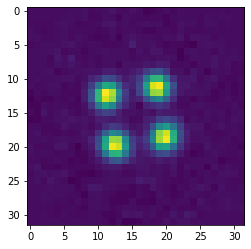

In [31]:
plt.imshow(final_model[0])

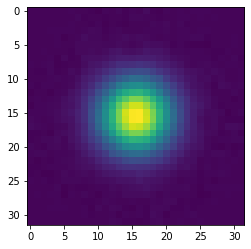

In [32]:
plt.imshow(final_model[1])

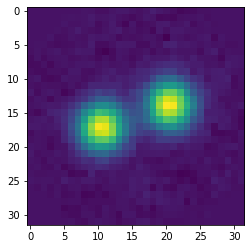

In [33]:
plt.imshow(final_model[2])